# 深層線形ニューラルネットの学習ダイナミクス

> A. M. Saxe, J. L. McClelland, S. Ganguli. "**A mathematical theory of semantic development in deep neural networks**". *PNAS.* (2019). ([arXiv](https://arxiv.org/abs/1810.10531)). ([PNAS](https://www.pnas.org/content/early/2019/05/16/1820226116))

## 知識の獲得とそのダイナミクス

### モデル
入力 $\mathbf{x}$ は「もの」の項目(例えばカナリア，犬，サーモン，樫など)，出力 $\mathbf{y}$はそれぞれの項目の性質・特性となっている．例えばカナリア(Canary)は成長し(Grow)，動き(Move)，空を飛べる(Fly)ので，Canaryという入力に対し，ネットワークが出力するのはGrow, Move, Flyとなる．モデルは3層の全結合線形ネットワークである．

$$
\hat{\mathbf{y}} =  \mathbf{ W} ^ {2} \mathbf{ W} ^ {1}\mathbf{x} 
$$

ただし非線形な活性化関数が無いことに注意しよう．このようなネットワークを線形ニューラルネットワーク (linear neural network)と呼ぶ．勘の良い読者であれば $ \mathbf{ W} ^ {s}=\mathbf{ W} ^ {2} \mathbf{W} ^ {1}$として， 上のネットワークは

$$
\hat{\mathbf{y}} =  \mathbf{ W} ^ {s}\mathbf{x}
$$

とまとめることができると気づくであろう．なので線形な活性化関数で深いニューラルネットワークを構築しても何の意味もなく，それゆえ非線形な活性化関数が必要となる．しかし，この論文では**深い(3層の)ネットワークである場合のみ，幼児の発達における非線形な現象が説明でき**，浅い(2層の)ネットワークでは当てはまらないことを示している．

### 学習
ネットワークの学習(重みの更新)は誤差逆伝搬から導かれる次の2式により行う．

$$
\begin{aligned} \tau \frac{d}{dt} \mathbf{ W} ^ {1}&=(\mathbf{W} ^ 2) ^ T ( \mathbf{\Sigma} ^ {yx} - \mathbf{W} ^ 2 \mathbf{W} ^ 1 \mathbf{\Sigma} ^ {x})\\
\tau \frac{d}{dt} \mathbf{W} ^ {2}&=(\mathbf{\Sigma} ^ {yx} - \mathbf{W} ^ {2} \mathbf{W} ^ 1 \mathbf{\Sigma} ^ {x}) (\mathbf{W} ^ 1)^\top
\end{aligned}
$$

ただし，$ \mathbf{\Sigma} ^ {x}$は入力間の関係を表す行列，$\mathbf{\Sigma} ^ {yx}$は入出力の関係を表す行列である．

### 特異値分解(SVD)による学習ダイナミクスの解析
学習ダイナミクスは$ \mathbf{\Sigma} ^ {yx}$に対する特異値分解(singular value decomposition; SVD)を用いて説明できる．

$$
\mathbf{\Sigma} ^ {yx}=\mathbf{USV}^\top
$$

行列$ \mathbf{ S}$の対角成分の非ゼロ要素が特異値である．次に学習途中の時刻$(t)$における$\hat{\mathbf{\Sigma}} ^ {yx}(t)=\mathbf{W} ^ 2 (t) \mathbf{W} ^ 1(t) \mathbf{\Sigma} ^ {x}$に対してSVDを実行し，特異値$\mathbf{A}(t)=[a_{\alpha}(t)]$を得る．この $a _ {\alpha}(t)$だが，3層のネットワークでは大きな特異値から先に学習されるのに対し，2層のネットワークでは全ての特異値が同時に学習される．このダイナミクスだが，**低ランク近似** (low-rank approximation)が生じていて，特異値の大きな要素から学習されていると捉えることができる．学習が進むとランクが大きくなっていく，ということである．低ランク近似の例として，SVDによる画像の圧縮と復元を見てみよう．カメラマンの画像に対し，低ランク近似を行い，ランクを上げていく．するとランクが上がるにつれて，画像が鮮明になる．

In [1]:
using PyPlot, LinearAlgebra, TestImages
eye(n) = Matrix(I, n, n)

eye (generic function with 1 method)

In [2]:
# Low-rank approximation with SVD
function LowRankApprox(U, s, V; rank=1)
    Ur, sr, Vr = U[:, 1:rank], s[1:rank], V[:, 1:rank]
    return Ur * diagm(sr) * Vr'
end;

In [9]:
img = convert(Array{Float64}, testimage("cameraman"));
U, s, V = svd(img); # PythonとJuliaでVに転置がかかっているか否かの違いあり．
ranklist = [1, 25, 50]
nr = length(ranklist)
img_approx = [LowRankApprox(U, s, V, rank=r) for r in ranklist];

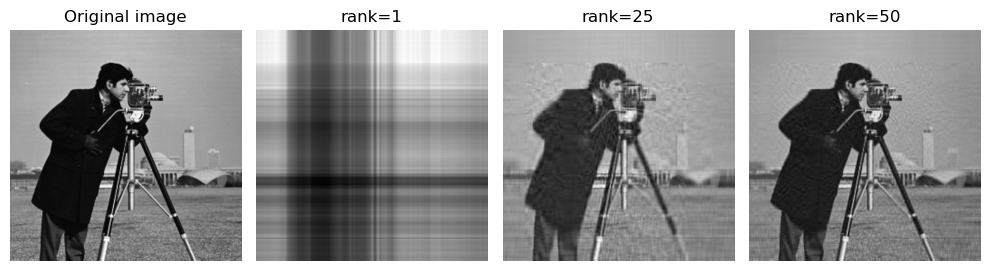

In [10]:
figure(figsize=(10, 3))
subplot(1, nr+1, 1); imshow(img, cmap="gray"); title("Original image"); axis("off")
for i in 1:nr
    subplot(1, nr+1, i+1); imshow(img_approx[i], cmap="gray"); title("rank="*string(ranklist[i])); axis("off")
end
tight_layout()

これと同じことが知識の獲得において生じていると見なすことができる．

## 3層・2層線形ニューラルネットの学習ダイナミクス

In [11]:
# Set initial values
N1, N2, N3 = 4, 16, 7
Σyx = [ones(4)'; ones(2)' zeros(2)'; zeros(2)' ones(2)'; eye(4)];
Σx = eye(N1)
u, s, v = svd(Σyx);
eps = 1e-2
W1, W2 = eps*rand(N2,N1), eps*rand(N3,N2) # weight for deep
Ws = eps*rand(N3,N1) # weight for shallow

#Simulation & training
dt = 0.005
Nt = 1500
A, B = zeros(Nt, N1), zeros(Nt, N1); # Singular values for deep, shallow

In [12]:
# Shallow network
for t in 1:Nt
    # Update weights
    Ws += (Σyx - Ws * Σx) * dt   
    # SVD & save results
    Σ̂yx = Ws * Σx
    _, a, _ = svd(Σ̂yx)
    B[t, :] += a
end

In [13]:
# Deep network
for t in 1:Nt
    # Update weights
    δ = Σyx - W2 * W1 * Σx
    W1 += (W2' * δ) * dt
    W2 += (δ * W1') * dt
    # SVD & save results
    Σ̂yx = W2 * W1 * Σx
    _, a, _ = svd(Σ̂yx)
    A[t, :] += a
end

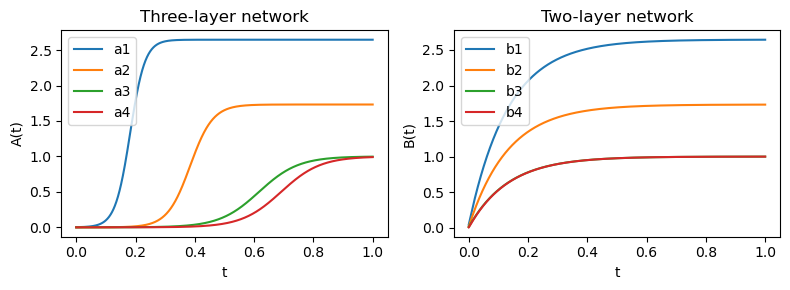

In [14]:
# Plot results
T = range(0, 1, length=Nt)
figure(figsize=(8,3))
subplot(1,2,1); title("Three-layer network")
plot(T, A[:,1], label="a1"); plot(T, A[:,2], label="a2"); 
plot(T, A[:,3], label="a3"); plot(T, A[:,4], label="a4")
xlabel("t"); ylabel("A(t)"); legend()
subplot(1,2,2); title("Two-layer network")
plot(T, B[:,1], label="b1"); plot(T, B[:,2], label="b2"); 
plot(T, B[:,3], label="b3"); plot(T, B[:,4], label="b4")
xlabel("t"); ylabel("B(t)"); legend()
tight_layout()

3層線形ネットワーク (deep)では大きな特異値から学習が始まっているのが分かる．また、それぞれの特異値の学習においてはシグモイド関数様の急速な学習段階が見られる．一方で2層線形ネットワーク (shallow)では全ての特異値の学習が初めから起こっていることがわかる．パラメータが少ないため，収束はこちらの方が速い．

このモデルが面白いの理由の一つとして，知識の混同（例えば『芋虫には骨がある』）の仕組みを提供することがある．発達において，大きい特異値から先に学習されるため，「動く」，「成長する」などの動物の要素が先に獲得される．身の回りの動物のほとんどが「骨を持つ」ので，**低ランク近似により，『芋虫にも骨がある』と錯覚してしまう**のではないか，という仮説が立てられる．